In [39]:
import numpy as np
import csv
import math
from matplotlib import pyplot as plt

CANDLE_CLOSE = 4

## Let's import BTC history 60s candle

In [41]:
with open("BTCUSDT.csv", mode='r') as csv_file:
    data = np.array(list(csv.reader(csv_file))).astype(float)

[38404.72 38324.9  38366.4  ... 43928.48 43922.8  43910.01]


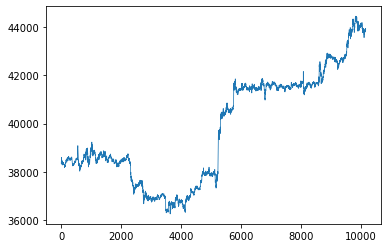

In [43]:
refined = data[:,CANDLE_CLOSE][:10150]
fig, ax = plt.subplots()
print(refined)
ax.plot(refined, linewidth=0.75)
plt.show()

# I am calculating an index (between 0 and 1) for each y 
#### If in the future 150 y, the value is mostly going up, then the index is going to be close to 1
#### If in the future 150 y, the value is mostly going down, then the index is going to be close to 0

##### I call it here : SELL_INDEX

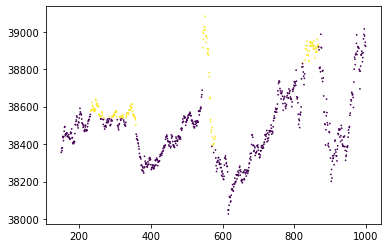

In [44]:
SELL_INDEX = np.zeros((len(refined), 1))

for index, row in enumerate(refined):
    
    if index > len(refined) - 150:
        continue

    max_price = np.amax(refined[index:index + 150])
    min_price = np.amin(refined[index:index + 150])
    
    current_sell_index = (row - min_price) / (max_price - min_price)
    
    SELL_INDEX[index][0] = 1 if current_sell_index > 0.8 else 0

data_with_sell_index = np.hstack((refined.reshape(-1,1), SELL_INDEX))
data_final =  np.hstack( (data_with_sell_index,  np.arange(len(data_with_sell_index)).reshape(-1, 1)) )
data_final = data_final[:len(data_final) - 150]
fig, ax = plt.subplots()
ax.scatter(data_final[150:1000][:,2], data_final[150:1000][:,0] , c = data_final[150:1000][:,1], s = .5)
plt.show()

# I set up the model 

In [51]:
import tensorflow as tf
from tensorflow.python.keras import models, Input, Model
from tensorflow.python import keras
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

## We implement a reducer for the learning rate


In [46]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 0.99
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)


In [47]:
input_layer = Input(shape=(150, 1))
layer_1_lstm = LSTM(50, return_sequences=True)(input_layer)
dropout_1 = Dropout(0.1)(layer_1_lstm)
layer_2_lstm = LSTM(50, return_sequences=True)(dropout_1)
dropout_2 = Dropout(0.1)(layer_2_lstm)
layer_3_lstm = LSTM(50)(dropout_2)

output_sell_index_proba = Dense(1, activation='sigmoid')(layer_3_lstm)

model = Model(inputs=input_layer, outputs=output_sell_index_proba)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 1)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 50)           10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51  

#### Batch generation, I associate the last sequence n - 150 to n with the n SELL_INDEX

In [48]:
def generate_batch(dataset_x, dataset_y, sequence_length):
    x_data, y_data = [], []
    for i in range(len(list(zip(dataset_x, dataset_y))) - sequence_length - 1):
        x_data.append(dataset_x[i:i + sequence_length])
        y_data.append(dataset_y[i + sequence_length])
    return np.array(x_data), np.array(y_data)

In [72]:
x, y = generate_batch(data_final[:,0][:9000], data_final[:,1][:9000], sequence_length=150)

scaler = MinMaxScaler(feature_range=(0, 1))
fitter = scaler.fit(x)
x = fitter.transform(x)

print(x.shape)

x = x.reshape(x.shape[0], x.shape[1], 1)
y = y.reshape(x.shape[0], 1, 1)

print(x.shape, y.shape)

model.fit(x, y, callbacks=[LearningRateReducerCb()], epochs=10,
                   validation_split=0.1, batch_size=64, verbose=1)

(8849, 150)
(8849, 150, 1) (8849, 1, 1)
Epoch 1/10
125/125 [==============================] - 26s 212ms/step - loss: 0.5074 - binary_accuracy: 0.7952 - val_loss: 0.4352 - val_binary_accuracy: 0.8475

Epoch: 0. Reducing Learning Rate from 0.0008863850380294025 to 0.0008775211754254997
Epoch 2/10
125/125 [==============================] - 26s 212ms/step - loss: 0.5075 - binary_accuracy: 0.7952 - val_loss: 0.4381 - val_binary_accuracy: 0.8475

Epoch: 1. Reducing Learning Rate from 0.0008775211754254997 to 0.0008687459630891681
Epoch 3/10
125/125 [==============================] - 26s 212ms/step - loss: 0.5075 - binary_accuracy: 0.7952 - val_loss: 0.4369 - val_binary_accuracy: 0.8475

Epoch: 2. Reducing Learning Rate from 0.0008687459630891681 to 0.000860058527905494
Epoch 4/10
125/125 [==============================] - 26s 212ms/step - loss: 0.5074 - binary_accuracy: 0.7952 - val_loss: 0.4325 - val_binary_accuracy: 0.8475

Epoch: 3. Reducing Learning Rate from 0.000860058527905494 to 0.00

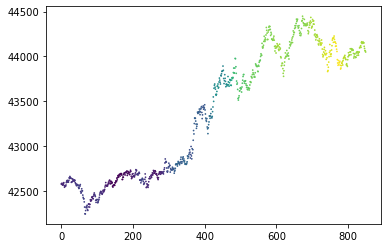

In [71]:
data = np.array(data_final[:,0][9000:])
results = np.array([])
for i in range (150, 1000):
    to_predict = fitter.transform(data[i - 150 : i].reshape(1, 150))
    result = model.predict(to_predict.reshape(1, 150, 1))
    results = np.append(result, results)
        
data = data[150:1000]

fig, ax = plt.subplots()
ax.scatter([range(len(data))], data.flatten() , c = results.flatten(), s= .5)
plt.show()